# SEPTA EDA, Delay Prediction, & *@SEPTA* Sentiment Analysis 

The purpose of this project is two-fold:

First, we will be analyzing the SEPTA trains dataset and seeing if we can extrapolate any kind of valuable insights about train delays (i.e. relationship between delays and time of day, station, weekday, etc). We will also attempt to forecast delays -- training a Random Forest model to predict a train's status given its timestamp, origin, destination, etc. 

Second, we will be looking at tweets directed at the SEPTA account and analyzing their sentiment. We will then try and extrapolate insights from these sentiments -- analyzing if any particular sentiment reigns supreme at certain times of day, weeks, etc. We will also try and see if the recent COVID-19 situation has had an effect on these sentiments. 

## Part 1: SEPTA EDA

In this section, we explore various questions -- including, but not limited to:

1.) What does the distribution of train delays look like?

2.) Are trains going to be later at particular times/days?

3.) Do certain stations suffer more from delays than others?

#### 1.1 Imports, loading data, and more!


In [0]:
import numpy as np
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
import os
from google.colab import drive

Unzip all of the data and place it in a new folder.

In [2]:
# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip "/content/gdrive/My Drive/CIS545_2020/on-time-performance.zip"

Archive:  /content/gdrive/My Drive/CIS545_2020/on-time-performance.zip
  inflating: database.sqlite         
  inflating: otp.csv                 
  inflating: trainView.csv           


Let's load our train data into a Pandas dataframe.

In [0]:
train_df = pd.read_csv('otp.csv')
train_df

,train_id,direction,origin,next_station,date,status,timeStamp
0,778,N,Trenton,Stenton,2016-03-23,1 min,2016-03-23 00:01:47
1,598,N,Thorndale,Narberth,2016-03-23,1 min,2016-03-23 00:01:58
2,279,S,Elm,Ridley Park,2016-03-23,2 min,2016-03-23 00:02:02
3,476,N,Airport Terminal E-F,Suburban Station,2016-03-23,On Time,2016-03-23 00:03:19
4,474,N,Airport Terminal E-F,Jenkintown-Wyncote,2016-03-23,On Time,2016-03-23 00:03:35
...,...,...,...,...,...,...,...
1882010,3520,N,Elwyn,University City,2016-11-06,12 min,2016-11-06 12:16:59
1882011,215,S,Elm,Allegheny,2016-11-06,7 min,2016-11-06 12:17:01
1882012,214,N,None,None,2016-11-06,On Time,2016-11-06 12:17:01
1882013,5338,N,None,None,2016-11-06,On Time,2016-11-06 12:17:02


#### 1.2 Data cleaning and pre-processing.

In this section, we're going to prepare some of our data for EDA. Let's drop all columns w/ None values.


In [0]:
train_df = train_df.dropna()

Let's convert our 'date' column to a datetime object, as well as process the 'status' column into a format we can later use (i.e. convert "On Time" = 1, "1 min" = 1, etc).

We will also split our datetime and timestamp columns into their individual components.



In [0]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].apply(lambda x : x.year)
train_df['month'] = train_df['date'].apply(lambda x : x.month)
train_df['day'] = train_df['date'].apply(lambda x : x.day)

In [0]:
train_df['timeStamp'] = pd.to_datetime(train_df['timeStamp'])
train_df['hour'] = train_df['timeStamp'].apply(lambda x : x.hour)
train_df['minute'] = train_df['timeStamp'].apply(lambda x : x.minute)
train_df['second'] = train_df['timeStamp'].apply(lambda x : x.second)

weekday_map = {
     0 : "Mon", 
     1 : "Tues",
     2 : "Wed",
     3 : "Thurs",
     4 : "Fri",
     5 : "Sat",
     6 : "Sun"
}
train_df['weekday'] = train_df['timeStamp'].apply(lambda x : 
                                                  weekday_map[x.weekday()])
train_df['weekday_num'] = train_df['timeStamp'].apply(lambda x : x.weekday())

We write a function parse_status to convert strings like "17 min" to just 17.

In [0]:
def parse_status(str):
  if (str == "On Time"):
    return 0
  else:
    return int(str.split(" ")[0].strip())
  
train_df['status'] = train_df['status'].apply(lambda x : parse_status(x))

In [0]:
train_df = train_df[train_df['status'] < 999]

#### 1.3 Plotting basic statistics

As an initial analysis, let's plot the range of delay times in histogram + box-plot formats.

In [0]:
import seaborn as sb

max_delay = train_df['status'].max()
min_delay = train_df['status'].min()
average_delay = train_df['status'].mean()
std_delay = train_df['status'].std()
print("Max Delay:", (max_delay), "minutes")
print("Min Delay:", (min_delay), "minutes")
print("Average Delay:", average_delay, "minutes")
print("STD:", std_delay, "minutes")

Max Delay: 500 minutes
Min Delay: 0 minutes
Average Delay: 4.179644557131581 minutes
STD: 6.567342522715621 minutes


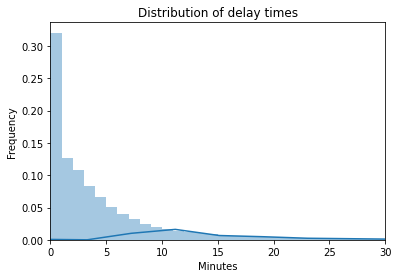

In [0]:
ax = sb.distplot(train_df['status'], bins=500)
plt.title("Distribution of delay times")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.xlim(0, 30)
plt.show()

Looks like most delay times range from 0-10 minutes, with some occasional outliers in the 20+ minute range.

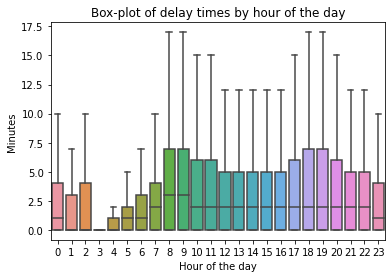

In [0]:
ax = sb.boxplot(x=train_df['hour'], y=train_df['status'], showfliers=False)
plt.title("Box-plot of delay times by hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("Minutes")
plt.show()

Seems like most delays are in the morning hours when people are going to work (8-9AM) and evening hours (5-7PM) when people are coming back from work (the mean here is lower, but the width of the given box is similar to the 8-9AM category). Makes sense!

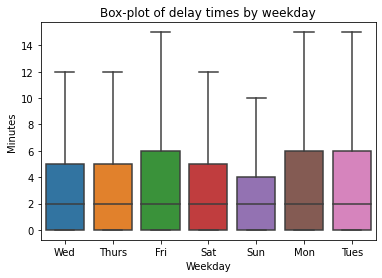

In [0]:
ax = sb.boxplot(x=train_df['weekday'], y=train_df['status'], showfliers=False)
plt.title("Box-plot of delay times by weekday")
plt.xlabel("Weekday")
plt.ylabel("Minutes")
plt.show()

Looks like Fridays, Mondays, and Tuesdays have more delays (not on average, but the range of delays is higher) -- although there  isn't *crazy* variation here.

#### 1.4 More-involved plotting

In this section, we'll be looking at EDA for some more involved questions! First, we'll be looking at whether or not some particular stations are more subject to being late.

In [0]:
!pip3 install pandasql

We'll create a new dataframe that contains average delays by origin station.

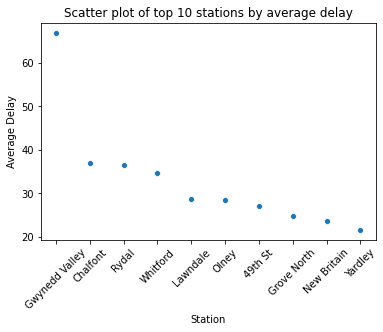

In [0]:
from pandasql import sqldf

pysqldf = lambda x : sqldf(x, globals())
q = """
SELECT origin, AVG(status) as avg_status
FROM train_df
GROUP BY origin
ORDER BY avg_status DESC
LIMIT 10
"""

top_10_stations = pysqldf(q)
ax = sb.scatterplot(x=top_10_stations['origin'], 
                    y=top_10_stations['avg_status'])
plt.title("Scatter plot of top 10 stations by average delay")
plt.xlabel("Station")
plt.ylabel("Average Delay")
ax.set_xticklabels(labels=top_10_stations['origin'], rotation=45)
plt.show()

Looks like the Gwynedd Valley trains are super, super late -- almost 2x as late as any other train stations. What's worth noting here is that this is likely result of an unfortunate day (i.e. one day, all of these trains were super late as the result of an accident, etc). Let's confirm this:

In [0]:
train_df[train_df['origin'] == 'Gwynedd Valley']

,train_id,direction,origin,next_station,date,status,timeStamp,year,month,day,hour,minute,second,weekday,weekday_num
1841399,583.,S,Gwynedd Valley,Penllyn,2016-11-01,64,2016-11-01 21:06:32,2016,11,1,21,6,32,Tues,1
1841403,583.,S,Gwynedd Valley,Ambler,2016-11-01,64,2016-11-01 21:07:19,2016,11,1,21,7,19,Tues,1
1841432,583.,S,Gwynedd Valley,North Hills,2016-11-01,62,2016-11-01 21:16:02,2016,11,1,21,16,2,Tues,1
1841442,583.,S,Gwynedd Valley,Glenside,2016-11-01,62,2016-11-01 21:18:55,2016,11,1,21,18,55,Tues,1
1841450,583.,S,Gwynedd Valley,Jenkintown-Wyncote,2016-11-01,62,2016-11-01 21:21:12,2016,11,1,21,21,12,Tues,1
1841533,583.,S,Gwynedd Valley,Temple U,2016-11-01,67,2016-11-01 21:40:26,2016,11,1,21,40,26,Tues,1
1841585,583.,S,Gwynedd Valley,Jefferson Station,2016-11-01,72,2016-11-01 21:50:26,2016,11,1,21,50,26,Tues,1
1841627,583.,S,Gwynedd Valley,30th Street Station,2016-11-01,74,2016-11-01 22:00:42,2016,11,1,22,0,42,Tues,1
1841673,583.,S,Gwynedd Valley,Overbrook,2016-11-01,75,2016-11-01 22:10:45,2016,11,1,22,10,45,Tues,1


Indeed, it looks like November 1th was a tough day for trains originating out of Gwynedd Valley. 

Let's regenerate this plot, but this time, require a minimum number of trains from this origin (to ensure that we're not getting too skewed by one-time events).

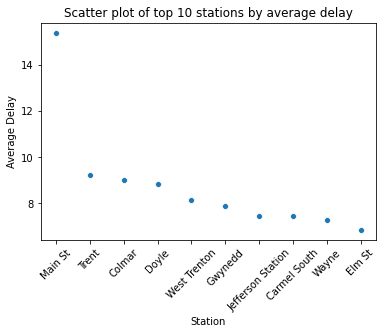

In [0]:
q = """
SELECT origin, COUNT(origin) as num, AVG(status) as avg_delay
FROM train_df
GROUP BY origin
ORDER BY num DESC
"""

temp = pysqldf(q)
temp = temp[temp['num'] > 1000]
top_10_stations = temp.sort_values(by=['avg_delay'], ascending=False)[0:10]
ax = sb.scatterplot(x=top_10_stations['origin'], 
                    y=top_10_stations['avg_delay'])
plt.title("Scatter plot of top 10 stations by average delay")
plt.xlabel("Station")
plt.ylabel("Average Delay")
ax.set_xticklabels(labels=top_10_stations['origin'], rotation=45)
plt.show()

This is a little better -- we can now see that trains coming out of the Main St station are, on average, a bit later than many other trains. We can also be more convinced that Main St is a real culprit, as it has over 1000 entries in our train dataframe. Let's do the same analysis, but for next_destination.

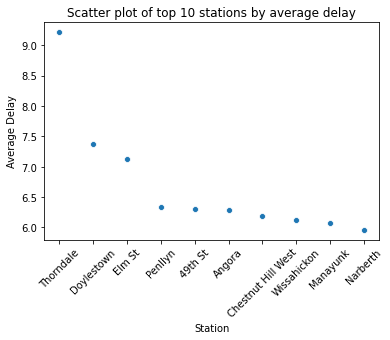

In [0]:
q = """
SELECT next_station, COUNT(origin) as num, AVG(status) as avg_delay
FROM train_df
GROUP BY next_station
ORDER BY num DESC
"""

#temp = pysqldf(q)
temp = temp[temp['num'] > 1000]
top_10_stations = temp.sort_values(by=['avg_delay'], ascending=False)[0:10]
ax = sb.scatterplot(x=top_10_stations['next_station'], 
                    y=top_10_stations['avg_delay'])
plt.title("Scatter plot of top 10 stations by average delay")
plt.xlabel("Station")
plt.ylabel("Average Delay")
ax.set_xticklabels(labels=top_10_stations['next_station'], rotation=45)
plt.show()

Looks like trains coming into Thorndale are, on average, much later than trains coming into any other station. 

Moral of this section: don't take a train going from Main St to Thorndale!

## Part 2: Delay Prediction

In this section, we explore PCA (dimensionality reduction) and Random Forests, and whether or not we can accurately predict a train's delay given its timestamp, origin, next station, and direction. 

Random Forests (in this case) are a natural choice -- as delays can likely be predicted in a very decision-tree-like fashion (i.e. what time is it? is the train arriving from this station? is it going to this station? etc).

#### 2.1 Setup and encoding for machine learning.

In this part, we'll be dropping all irrelevant columns and encoding all categorical data w/ one-hot vectors. We will include time information (month, day, hour, minute, second, and weekday_num) columns, as this may provide useful information to our machine learning models. 

In [0]:
train_df

,train_id,direction,origin,next_station,date,status,timeStamp,year,month,day,hour,minute,second,weekday
0,778,N,Trenton,Stenton,2016-03-23,1,2016-03-23 00:01:47,2016,3,23,0,1,47,Wed
1,598,N,Thorndale,Narberth,2016-03-23,1,2016-03-23 00:01:58,2016,3,23,0,1,58,Wed
2,279,S,Elm,Ridley Park,2016-03-23,2,2016-03-23 00:02:02,2016,3,23,0,2,2,Wed
3,476,N,Airport Terminal E-F,Suburban Station,2016-03-23,0,2016-03-23 00:03:19,2016,3,23,0,3,19,Wed
4,474,N,Airport Terminal E-F,Jenkintown-Wyncote,2016-03-23,0,2016-03-23 00:03:35,2016,3,23,0,3,35,Wed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882010,3520,N,Elwyn,University City,2016-11-06,12,2016-11-06 12:16:59,2016,11,6,12,16,59,Sun
1882011,215,S,Elm,Allegheny,2016-11-06,7,2016-11-06 12:17:01,2016,11,6,12,17,1,Sun
1882012,214,N,None,None,2016-11-06,0,2016-11-06 12:17:01,2016,11,6,12,17,1,Sun
1882013,5338,N,None,None,2016-11-06,0,2016-11-06 12:17:02,2016,11,6,12,17,2,Sun


In [0]:
train_df_clean = train_df.drop(labels=['train_id', 'weekday', 'date', 'year', 
                                       'timeStamp', 'date'], 
                               axis=1)

#### 2.2 One-hot encoding 

Let's one-hot encode the categorical columns that we care about! We expect to see a very large resulting DF, as there is a large number of origins/destinations. 

In [0]:
train_df_clean = pd.get_dummies(train_df_clean, columns=["direction", "origin",
                      "next_station"])

In [0]:
train_df_clean

,status,month,day,hour,minute,second,weekday_num,direction_N,direction_S,origin_16th St Jct,origin_20th St,origin_30th South,origin_30th Street Station,origin_49th St,origin_60th St North,origin_9th St,origin_Airport Jct,origin_Airport Terminal A,origin_Airport Terminal B,origin_Airport Terminal C-D,origin_Airport Terminal E-F,origin_Allegheny,origin_Allen Lane,origin_Ambler,origin_Angora,origin_Ardmore,origin_Ardsley,origin_Arsenal,origin_Bala,origin_Bethayres,origin_Bridge,origin_Bristol,origin_Broad,origin_Bryn Mawr,origin_Bryn Mawr Int,origin_CP-North Elwyn,origin_CP-Wood,origin_Cane,origin_Carmel,origin_Carmel South,...,next_station_Roslyn,next_station_Rydal,next_station_Ryers,next_station_Secane,next_station_Sedgwick,next_station_Sharon Hill,next_station_Somerton,next_station_Spring Mill,next_station_St. Davids,next_station_St. Martins,next_station_Stenton,next_station_Strafford,next_station_Suburban Station,next_station_Swarthmore,next_station_Tacony,next_station_Temple U,next_station_Thorndale,next_station_Torresdale,next_station_Trenton,next_station_Trevose,next_station_Tulpehocken,next_station_University City,next_station_Upsal,next_station_Villanova,next_station_Wallingford,next_station_Warminster,next_station_Washington Lane,next_station_Wayne Jct,next_station_Wayne-A,next_station_West Trenton,next_station_Whitford,next_station_Willow Grove,next_station_Wilmington,next_station_Wissahickon,next_station_Wister,next_station_Woodbourne,next_station_Wyndmoor,next_station_Wynnefield Avenue,next_station_Wynnewood,next_station_Yardley
0,1,3,23,0,1,47,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3,23,0,1,58,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,3,23,0,2,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,3,23,0,3,19,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,3,23,0,3,35,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882010,12,11,6,12,16,59,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1882011,7,11,6,12,17,1,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1882012,0,11,6,12,17,1,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1882013,0,11,6,12,17,2,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 2.3 Splitting our dataset & PCA

Let's split our data into features and labels, as well as create test/train splits. We use a 80:20 split. 

In [0]:
from sklearn.model_selection import train_test_split

features = train_df_clean.loc[:, train_df_clean.columns != "status"]
labels = train_df_clean['status']

x_train, x_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size = 0.2)

Let's also run PCA and see if there's anyway we can remove the number of components we keep.

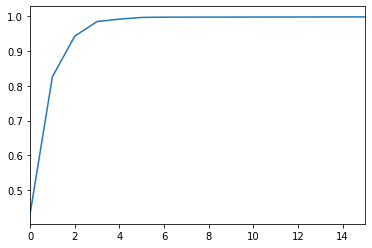

In [0]:
from sklearn.decomposition import PCA

pca = PCA()
pca_features = pca.fit_transform(x_train)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
plt.xlim(0, 15)
plt.plot(pc_vs_variance)

This graph is misleading! We forgot to scale our features, so the PCA isn't accurate. Let's re-run the above, but scale our train dataset w/ sklearn's StandardScaler first.

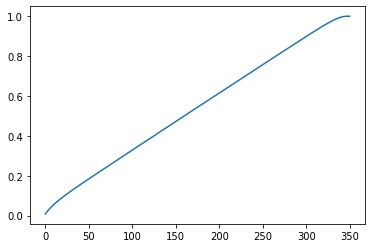

In [0]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(x_train)
pca = PCA()
pca_features = pca.fit_transform(X)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(pc_vs_variance)

The above graph is pretty much linear, which makes sense, as we didn't expect there to be too much correlation between our columns; so, we won't be using PCA to train our random forest. 

In the below section, we will find optimal parameters for our RandomForestRegressor by running a grid search. We will be tuning the n_estimators, max_features

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

param_grid = {
    'n_estimators' : [5, 10, 25],
    'max_depth' : [5, 10, 20],
    'min_samples_split' : [2, 5, 10]
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

The grid search (output no longer shown, but too long to rerun) tells us that the best parameters are 25 estimators, a high maximum depth, and a low min samples split. 

It's worth noting that we limit the number of estimators we have to be upper-bounded by 25, as going any higher increases training time to impractical levels (training a RandomForestRegressor w/ 200 estimators didn't terminate after 18 hours). 

#### 2.4 Training + Results 

First, we train a Random Forest Regressor w/ max_depth 5 and see if this will suffice.

In [0]:
rf = RandomForestRegressor(n_estimators = 100, max_depth = 5, 
                           min_samples_split = 2)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import mean_squared_error

prediction = rf.predict(x_test)
prediction_score = rf.score(x_test, y_test)
prediction_train = rf.predict(x_train)
prediction_train_score = rf.score(x_train, y_train)
print("Test prediction accuracy:", prediction_score)
print("Train prediction accuracy:", prediction_train_score)


Test prediction accuracy: 0.1414871516692625
Train prediction accuracy: 0.14797494960125657


These results are extremely lackluster -- and for good reason. Limiting our depth to 5 likely means that the model can't capture a good amount of granularity coming from the train's origin/destination stations.

We re-train a new model with no maximum depth but limit the number of estimators (as training with anything over 25 takes too long). 

In [0]:
rf2 = RandomForestRegressor(n_estimators = 25)
rf2.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
prediction_score = rf2.score(x_test, y_test)
prediction_train_score = rf2.score(x_train, y_train)
print("Test prediction accuracy:", prediction_score)
print("Train prediction accuracy:", prediction_train_score)

Test prediction accuracy: 0.687836846440559
Train prediction accuracy: 0.9505761681152539


Even though the # of estimators goes down to 25, we still achieve much better accuracy -- nearly 70% -- on our test set. It isn't hard to imagine that, with more powerful hardware and more time, we could achieve much higher accuracy with a higher number of estimators.

Since we are using a Random Forest and not a neural network, lets also take advantage of the fact that we can see the relative importance of features in the Random Forest. 

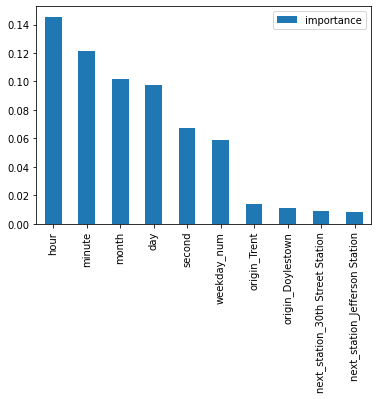

In [0]:
importances = rf2.feature_importances_
importance_df = pd.DataFrame(importances, index=x_test.columns, columns=['importance']).sort_values('importance', ascending=False)
importance_df[0:10].plot.bar()

The above histogram reveals a really interesting point -- roughly half of the importance is attributed to nothing but a train's timestamp! This makes sense, as delays are likely triggered by an event (crash, stoppage, etc) that then affects other trains operating on the same line/within a similar time period; knowing when a train is leaving is actually really powerful!

After weekday_num, we see that the RF then starts evaluating various origins/next destinations, which is also to be expected (as some particular origins or destinations may be closely correlated with no delays or high delays). 

## Part 3: Sentiment Analysis

In this section, we train a sentiment analyzer on a large Twitter dataset, and then apply it to a dataset of SEPTA tweets to see if we can extrapolate any kind of interesting information/insights. 

This analysis is motivated by the hypothesis that -- if we take a look at tweets directed at SEPTA -- we will see an overwhelmingly negative majority. Furthermore, we might find that, in the past 2 months (as COVID-19 has sparked)-- negative sentiment has increased even further (a result of people seeing SEPTA not taking action against COVID, being dissapointed about lack of sanitation, etc).

We will be using an LSTM and transfer-learning on a Twitter sentiment dataset, which is linked in section 3.4.

#### 3.1 Acquiring the data and cleaning

We use a pypi library called twitter-scraper to scrape all tweets directed at the twitter account, @SEPTA. This was done locally and exported to a json file, that is imported into a pandas dataframe below. 

In [0]:
septa_tweets = pd.read_json('/content/gdrive/My Drive/CIS545_2020/tweets_real_2.json')

In [0]:
septa_tweets['timestamp'] = pd.to_datetime(septa_tweets['timestamp'])
septa_tweets = septa_tweets.sort_values(by='timestamp', ascending=False)

In [5]:
septa_tweets

,has_media,hashtags,img_urls,is_replied,is_reply_to,likes,links,parent_tweet_id,replies,reply_to_users,retweets,screen_name,text,text_html,timestamp,timestamp_epochs,tweet_id,tweet_url,user_id,username,video_url
4766,True,[],[https://pbs.twimg.com/media/EWpaJIYWkAMGh04.j...,False,False,0,[],,0,[],1,BuckleGarage,@SEPTA @SEPTA_SOCIAL @SEPTAPHILLY @NBCPhiladel...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2020-04-27 23:25:21,2020-04-27 23:25:21,1254914563050438656,/BuckleGarage/status/1254914563050438658,532634473,lex,
4786,True,[],[https://pbs.twimg.com/media/EWpaJIYWkAMGh04.j...,False,False,0,[],,0,[],1,BuckleGarage,@SEPTA @SEPTA_SOCIAL @SEPTAPHILLY @NBCPhiladel...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2020-04-27 23:25:21,2020-04-27 23:25:21,1254914563050438656,/BuckleGarage/status/1254914563050438658,532634473,lex,
4767,False,[],[],True,False,2,[],,3,[],0,violentrenegade,@SEPTA why do you insist that everyone has to ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2020-04-27 23:12:19,2020-04-27 23:12:19,1254911281301159936,/violentrenegade/status/1254911281301159939,876201176966025216,dEEbz,
4787,False,[],[],True,False,2,[],,3,[],0,violentrenegade,@SEPTA why do you insist that everyone has to ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2020-04-27 23:12:19,2020-04-27 23:12:19,1254911281301159936,/violentrenegade/status/1254911281301159939,876201176966025216,dEEbz,
4788,False,[],[],True,False,1,[],,1,[],0,fuckallyall215,@septa this new schedule shit is bs more waiti...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2020-04-27 19:35:25,2020-04-27 19:35:25,1254856696851165184,/fuckallyall215/status/1254856696851165185,28396717,Meh Reg,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,False,[],[],False,True,0,[],983621535,0,"[{'screen_name': 'SEPTA', 'user_id': '16358930'}]",0,merecat,@SEPTA reports trains running on or close to s...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2008-10-31 12:03:26,2008-10-31 12:03:26,983627792,/merecat/status/983627792,6347762,Tony Green,
38,False,[],[],False,True,0,[],960971839,0,"[{'screen_name': 'SEPTA', 'user_id': '16358930'}]",0,radiocolin,@septa and @njtwatch are insanely annoying in ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2008-10-15 20:49:16,2008-10-15 20:49:16,961192521,/radiocolin/status/961192521,14165162,Colin,
18,False,[],[],False,True,0,[],960971839,0,"[{'screen_name': 'SEPTA', 'user_id': '16358930'}]",0,radiocolin,@septa and @njtwatch are insanely annoying in ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2008-10-15 20:49:16,2008-10-15 20:49:16,961192521,/radiocolin/status/961192521,14165162,Colin,
39,False,[],[],False,True,0,[],932976871,0,"[{'screen_name': 'SEPTA', 'user_id': '16358930'}]",0,haveboard,@septa driver can kiss my ass for looking at m...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2008-09-25 22:19:43,2008-09-25 22:19:43,934957737,/haveboard/status/934957737,9000272,haveboard,


#### 3.2 Installing dependencies

Great! Now that we've imported our SEPTA tweets -- we now need to figure out how to classify their sentiment. We will do this by creating an LSTM, a type of RNN (recurrent neural network) that is particulary good at capturing context in long sentences. 

We will be utilizing mxnet along with gluonnlp, a library that comes with pre-trained word embeddings (i.e. low-level representations of words).

In [6]:
!pip3 install gluonnlp

     |████████████████████████████████| 256kB 3.4MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.9.1-cp36-cp36m-linux_x86_64.whl size=471067 sha256=e2d040eab3f6370b0e6d41de7a3b11c1e5af5624e64376528ade6daf42ad9713
  Stored in directory: /root/.cache/pip/wheels/af/60/16/1f8a40e68b85bd9bd7960e91830bca5e40cd113f3220b7e231
Successfully built gluonnlp


In [7]:
!pip3 install mxnet-cu101

     |████████████████████████████████| 710.5MB 25kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [8]:
!pip3 install --upgrade mxnet-cu101 gluoncv

Requirement already up-to-date: mxnet-cu101 in /usr/local/lib/python3.6/dist-packages (1.6.0)
     |████████████████████████████████| 757kB 3.5MB/s 


#### 3.3 Network architecture

We will be utilizing mean pooling, rather than max pooling, for the sentiment classification problem. 

Our main network itself (defined below as SentimentNet) will consist of an embedding and encoder layers (which are pre-trained and provided by gluonnlp), a mean pooling layer, a fully connected dense layer w/ RELU activation, and finally, a final, single neuron output layer (which will contain the probability that our sentence is negative/positive).

In [0]:
import gluonnlp as nlp
import mxnet as mx
from mxnet import nd, gluon, autograd 

class MeanPoolingLayer(gluon.HybridBlock):
    def __init__(self, prefix=None, params=None):
        super(MeanPoolingLayer, self).__init__(prefix=prefix, params=params)

    def hybrid_forward(self, F, data, valid_length): 
        masked_encoded = F.SequenceMask(data,
                                        sequence_length=valid_length,
                                        use_sequence_length=True)
        agg_state = F.broadcast_div(F.sum(masked_encoded, axis=0),
                                    F.expand_dims(valid_length, axis=1))
        return agg_state


class SentimentNet(gluon.HybridBlock):
    def __init__(self, dropout, prefix=None, params=None):
        super(SentimentNet, self).__init__(prefix=prefix, params=params)
        with self.name_scope():
            self.embedding = None 
            self.encoder = None 
            self.agg_layer = MeanPoolingLayer()
            self.dense1 = gluon.nn.Dense(150, activation='relu')
            self.output = gluon.nn.Dense(1, flatten=True)

    def hybrid_forward(self, F, data, valid_length): 
        encoded = self.encoder(self.embedding(data))  
        agg_state = self.agg_layer(encoded, valid_length)
        middle = self.dense1(agg_state)
        final = self.output(middle)
        return final

We download the pre-trained LSTM model here, as well as set our learning rate (10^-3) and batch size.

In [0]:
dropout = 0
language_model_name = 'standard_lstm_lm_200'
pretrained = True
learning_rate, batch_size = 0.001, 32
bucket_num, bucket_ratio = 10, 0.2
epochs = 1
grad_clip = None
log_interval = 100

In [0]:
context = mx.gpu(0)

In [12]:
lm_model, vocab = nlp.model.get_model(name=language_model_name,
                                      dataset_name='wikitext-2',
                                      pretrained=pretrained,
                                      ctx=context,
                                      dropout=dropout)

Vocab file is not found. Downloading.


Finally, we initialize our SentimentNet -- setting the embedding/encoder layers to the pre-trained weights and initializing our second-to-last and final dense layers. 

In [13]:
net = SentimentNet(dropout=dropout)
net.embedding = lm_model.embedding
net.encoder = lm_model.encoder
net.hybridize()
net.dense1.initialize(mx.init.Xavier(), ctx=context)
net.output.initialize(mx.init.Xavier(), ctx=context)
print(net)

SentimentNet(
  (embedding): HybridSequential(
    (0): Embedding(33278 -> 200, float32)
  )
  (encoder): LSTM(200 -> 200, TNC, num_layers=2)
  (agg_layer): MeanPoolingLayer(
  
  )
  (dense1): Dense(None -> 150, Activation(relu))
  (output): Dense(None -> 1, linear)
)


#### 3.4 Loading/cleaning training data

Instead of training on the SEPTA tweets (which are unlabeled), we instead train on the Kaggle Twitter140 dataset, which contains 1.6 million positive/negative tweets (800k of each). The dataset is linked here: https://www.kaggle.com/kazanova/sentiment140. The reasoning behind this is that the SEPTA tweets should be written in similar style/language to other tweets -- so training on a much larger sample size of a similar domain should be sufficient.

First, we drop the irrelevant columns and re-cast negative sentiment to 0 and positive to 1.

In [14]:
columns = ["target", "id", "date", "flag", "user", "text"]
sentiment_df = pd.read_csv('/content/gdrive/My Drive/CIS545_2020/emotion.csv', 
                           encoding="ISO-8859-1", names=columns, header=None)
sentiment_df['target'] = sentiment_df['target'].apply(lambda x : 0 if (x == 0) 
                                                          else 1)
sentiment_df = sentiment_df.drop(labels=['id', 'date', 'flag', 'user'], axis=1)
sentiment_df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


We now utilize a library called tweet-preprocessor to clean our tweets; this is simply easier to do than manually filtering the string with regular expressions. 

In [15]:
!pip3 install tweet-preprocessor

  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-cp36-none-any.whl size=7947 sha256=d7f2cff19a17bba9f1105c9c0ac32b4cfec55a4c2bbb55c4cc917f28682b599a
  Stored in directory: /root/.cache/pip/wheels/1b/27/cc/49938e98a2470802ebdefae9d2b3f524768e970c1ebbe2dc4a
Successfully built tweet-preprocessor


In [0]:
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.HASHTAG, p.OPT.MENTION)

In [0]:
import re

def clean_string(string):
    '''
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"http\S+", "", string)
    '''
    return p.clean(string).lower()

# clean strings in the dataframe
sentiment_df.text = sentiment_df.text.apply(lambda x : clean_string(x))

After cleaning, we also want to drop all tweets that have become empty.

In [0]:
sentiment_df = sentiment_df[sentiment_df['text'] != ""]

We define a preprocess function that will tokenize a sentence; what this means is, given a sentence such as, "The cat is walking," we want to represent this as an array of integers, such as [20, 14, 15, 300]. 

To do this, we use a tokenizer imported from gluonnlp. We also clip all tweets greater than 500 characters.

In [0]:
# tokenize a given string
tokenizer = nlp.data.SpacyTokenizer('en')
length_clip = nlp.data.ClipSequence(500)

# Helper function to preprocess a single data point
def preprocess(x):
    label, data = x
    # A token index or a list of token indices is
    # returned according to the vocabulary.
    data = vocab[length_clip(tokenizer(data))]
    return data, label

Below, we create our test and train splits, once again using a 80:20 ratio. 

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(sentiment_df, test_size=0.2)
train_dataset = train.to_numpy()
test_dataset = test.to_numpy()

Now that we have our train and test samples, we still need to tokenize them before we can train using them. This is done using python's built-in multiprocessing library.

In [21]:
import time
import multiprocessing as mp 

def preprocess_dataset(dataset):
    start = time.time()
    with mp.Pool() as pool:
        dataset = gluon.data.SimpleDataset(pool.map(preprocess, dataset))
    end = time.time()
    print('Done! Tokenizing Time={:.2f}s, #Sentences={}'.format(end - start, len(dataset)))
    return dataset

# Doing the actual pre-processing of the dataset
train_dataset = preprocess_dataset(train_dataset)
test_dataset = preprocess_dataset(test_dataset)

Done! Tokenizing Time=77.30s, #Sentences=1277558
Done! Tokenizing Time=19.64s, #Sentences=319390


Finally, we create train and test DataLoader objects to be fed into our training function. We specify a batch size of 32 for the training data and 16 for the testing data. We also define a batchify function that pads our input data.

In [0]:
def get_dataloader():
    # Construct a DataLoader object for both the training and test data
    batchify_fn = nlp.data.batchify.Tuple(
        nlp.data.batchify.Pad(axis=0, pad_val=0, ret_length=True),
        nlp.data.batchify.Stack(dtype='float32'))
    train_dataloader = gluon.data.DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
        batchify_fn=batchify_fn)
    test_dataloader = gluon.data.DataLoader(
        dataset=test_dataset,
        batch_size=16,
        shuffle=False,
        batchify_fn=batchify_fn)
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = get_dataloader()

#### 3.5 Evaluation and training

We create an evaluate function that evaluates our network against a test dataset. We will use binary cross-entropy loss in this function.

In [0]:
def evaluate(net, dataloader, context):
    loss = gluon.loss.SigmoidBCELoss()
    total_L = 0.0
    total_sample_num = 0
    total_correct_num = 0
    start_log_interval_time = time.time()

    print('Begin Testing...')
    for i, ((data, valid_length), label) in enumerate(dataloader):
        data = mx.nd.transpose(data.as_in_context(context))
        valid_length = valid_length.as_in_context(context).astype(np.float32)
        label = label.as_in_context(context)
        output = net(data, valid_length)

        L = loss(output, label)
        pred = (output > 0.5).reshape(-1)
        total_L += L.sum().asscalar()
        total_sample_num += label.shape[0]
        total_correct_num += (pred == label).sum().asscalar()

        if (i + 1) % log_interval == 0:
            print('[Batch {}/{}] elapsed {:.2f} s'.format(
                i + 1, len(dataloader),
                time.time() - start_log_interval_time))
            start_log_interval_time = time.time()

    avg_L = total_L / float(total_sample_num)
    acc = total_correct_num / float(total_sample_num)

    return avg_L, acc

Our train function is structured similarly to any other neural network training function. We iterate through the batches/samples in our train loader, generate predictions, and backpropogate. Every 100 batches, we print out the current loss.

Since this is a transfer learning approach, we will only need to run 1 epoch (as we are only training the last couple layers; most of the network is "frozen").

In [0]:
def train(net, context, epochs):
    trainer = gluon.Trainer(net.collect_params(), 'ftml',
                            {'learning_rate': learning_rate})
    loss = gluon.loss.SigmoidBCELoss()

    parameters = net.collect_params().values()

    # Training/Testing
    for epoch in range(epochs):
        # Epoch training stats
        start_epoch_time = time.time()
        epoch_L = 0.0
        epoch_sent_num = 0
        epoch_wc = 0
        # Log interval training stats
        start_log_interval_time = time.time()
        log_interval_wc = 0
        log_interval_sent_num = 0
        log_interval_L = 0.0

        for i, ((data, length), label) in enumerate(train_dataloader):
            L = 0
            wc = length.sum().asscalar()
            log_interval_wc += wc
            epoch_wc += wc
            log_interval_sent_num += data.shape[1]
            epoch_sent_num += data.shape[1]
            with autograd.record():
                output = net(data.as_in_context(context).T,
                             length.as_in_context(context)
                                   .astype(np.float32))
                L = L + loss(output, label.as_in_context(context)).mean()
            L.backward()

            if grad_clip:
                gluon.utils.clip_global_norm(
                    [p.grad(context) for p in parameters],
                    grad_clip)

            trainer.step(1)
            log_interval_L += L.asscalar()
            epoch_L += L.asscalar()
            if (i + 1) % log_interval == 0:
                print(
                    '[Epoch {} Batch {}/{}] elapsed {:.2f} s, '
                    'avg loss {:.6f}, throughput {:.2f}K wps'.format(
                        epoch, i + 1, len(train_dataloader),
                        time.time() - start_log_interval_time,
                        log_interval_L / log_interval_sent_num, log_interval_wc
                        / 1000 / (time.time() - start_log_interval_time)))

                start_log_interval_time = time.time()
                log_interval_wc = 0
                log_interval_sent_num = 0
                log_interval_L = 0
        end_epoch_time = time.time()
        test_avg_L, test_acc = evaluate(net, test_dataloader, context)
        print('[Epoch {}] train avg loss {:.6f}, test acc {:.2f}, '
              'test avg loss {:.6f}, throughput {:.2f}K wps'.format(
                  epoch, epoch_L / epoch_sent_num, test_avg_L, test_acc,
                  epoch_wc / 1000 / (end_epoch_time - start_epoch_time)))

In [49]:
train(net, context, epochs)

[...]
[Epoch 0 Batch 39800/39924] elapsed 0.65 s, avg loss 0.010359, throughput 75.12K wps
[Epoch 0 Batch 39900/39924] elapsed 0.65 s, avg loss 0.010354, throughput 75.12K wps


The final average loss was ~0.0103, and the final test accuracy was ~0.74. The above was terminated early in favor of time.

#### 3.6 SEPTA Analysis

Now that we've trained our network -- its time to do some analysis! We start off by cleaning the SEPTA tweets (in a similar manner to how we cleaned the Twitter140 dataset). 

In [47]:
septa_tweets['text'] = septa_tweets['text'].apply(lambda x : clean_string(x).strip())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Next, we define a function get_prediction that makes it super easy for us to input a sentence and get an output sentiment (closer to 0 indicates negative, closer to 1 indicates positive). 

In [48]:
def get_prediction(x):
  split = [word.strip() for word in x.split()]
  arr = mx.nd.array(vocab[split])
  if (len(arr) == 0):
    return -1
  return net(
    mx.nd.reshape(
        mx.nd.array(arr, ctx=context),
        shape=(-1, 1)), mx.nd.array([len(split)], ctx=context)).sigmoid()[0].asscalar() 

septa_tweets['prediction'] = septa_tweets['text'].apply(lambda x : get_prediction(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Its worth noting that we only want to keep values >= 0, so we filter the septa_tweets dataset to reflect this.

For validation purposes, lets also look at some of the tweets labeled with a sentiment >= 0.95 and some of the tweets labeled with a sentiment of <= 0.05 to make sure our network wasn't *too* far off. 

In [66]:
random_indices = np.random.choice(510, 5)
print("Positive:")
for i in range(5):
  print(septa_tweets[septa_tweets['prediction'] >= 0.95]['text'].values[random_indices[i]])

print("Negative:")
for i in range(5):
  print(septa_tweets[septa_tweets['prediction'] <= 0.05]['text'].values[random_indices[i]])

Positive:
is the 10 trolley running with delays?
the conductor and driver of the current manayunk/norristown line regional rail are awesome guys. extremely helpful, kudos to them
- will an upgraded student trans pass be honored on regional rail thursday? thanks.
thank you amy for tweeting this. you are such angel of an individual and human being. thank you.
absolutely love your new rides! aka
Negative:
why did train 521 have only two cars?
your 108 bus number 5884 picked up at the airport with the sign "69th st" but went to airport business center causing everyone to miss the actual 69th st. bus.
why did the 22 bus ride pass me number 3311
why are we still only paying with cash when we get on the regional rail? most of us clearly have cards, let us swipe when the station doesn’t offer tickets. kicking me off the train is extremely outside of 2018
spent 2.5 hours on the bus today for a trip that normally takes less than 30 min. the driver took a different route due to traffic. he said t

In the above random run, it looks like our network does a pretty good job of distinguishing between positive/negaive sentiment. However, it's worth noting that, in some runs of the above cell -- some sarcastic comments would end up being labeled as positive (ex: "Thanks for nothing, SEPTA!").

Let's quickly look at the distribution of sentiment in tweets.

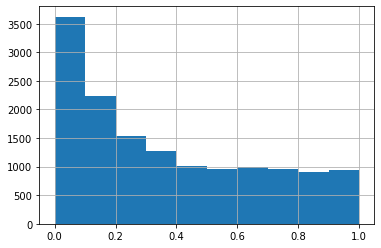

In [51]:
septa_tweets['prediction'].hist()

Nice, this is basically what we expected: skewed strongly to the right.

Below, we're now going to look at sentiment as a function of weekday.

In [67]:
import seaborn as sb 

weekday_map = {
     0 : "Mon", 
     1 : "Tues",
     2 : "Wed",
     3 : "Thurs",
     4 : "Fri",
     5 : "Sat",
     6 : "Sun"
}
septa_tweets['weekday'] = septa_tweets['timestamp'].apply(lambda x : 
                                                  weekday_map[x.weekday()])
septa_tweets['weekday_num'] = septa_tweets['timestamp'].apply(lambda x : 
                                                              x.weekday())
septa_tweets['hour'] = septa_tweets['timestamp'].apply(lambda x : 
                                                              x.hour)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


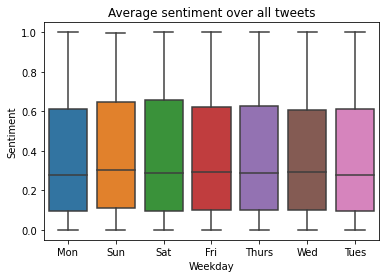

0.36957348360363346


In [71]:
ax = sb.boxplot(x=septa_tweets['weekday'], y=septa_tweets['prediction'], showfliers=False)
plt.title("Average sentiment over all tweets")
plt.xlabel("Weekday")
plt.ylabel("Sentiment")
plt.show()
print(septa_tweets['prediction'].mean())

It looks like general sentiment across weekdays doesn't seem to vary *too* much; Sunday seems to be slightly higher, possibly because there aren't as many riders. However, this plot is consistent with our hypothesis that -- generally -- people tweet @SEPTA when they are unhappy (mean sentiment of **0.37**).

Let's look at this same plot now, except with values from the last 2 months (i.e. COVID time).


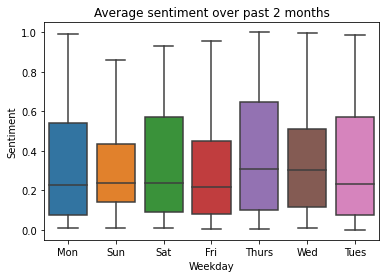

0.3400867182861382


In [72]:
ax = sb.boxplot(x=septa_tweets['weekday'][1:800], y=septa_tweets['prediction'][1:800], showfliers=False)
plt.title("Average sentiment over past 2 months")
plt.xlabel("Weekday")
plt.ylabel("Sentiment")
plt.show()
print(septa_tweets['prediction'][1:800].mean())

Interesting! It looks like, during COVID, average sentiment dropped to **0.34**. The average on some weekdays (Monday, Tuesday, Friday) seems to be noticeably lower. Let's see if we can dig into this more!

Let's plot average sentiment over *the hours* of the day (over all time vs last two months) and see if there's anything interesting! 

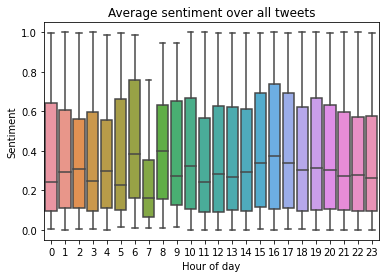

In [76]:
ax = sb.boxplot(x=septa_tweets['hour'], y=septa_tweets['prediction'], showfliers=False)
plt.title("Average sentiment over all tweets")
plt.xlabel("Hour of day")
plt.ylabel("Sentiment")
plt.show()

It seems like sentiment dips around 7AM, but overall, the averages across hours seem to be relatively consistent. 

Now, for sentiment versus hour for the past 2 months:

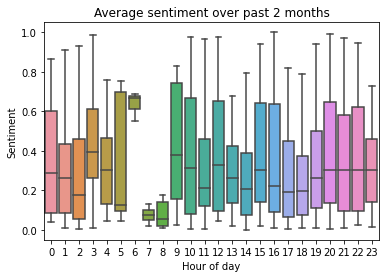

In [77]:
ax = sb.boxplot(x=septa_tweets['hour'][1:800], y=septa_tweets['prediction'][1:800], showfliers=False)
plt.title("Average sentiment over past 2 months")
plt.xlabel("Hour of day")
plt.ylabel("Sentiment")
plt.show()

Barring the outlier 6AM (not sure why this would be super positive during COVID) -- there's a clear dip in the 7-8AM and 5-7PM sentiments during COVID.

This is likely the case as it is when most people are getting on the SEPTA (going to work or from work) -- which means this is when they would express their disatisfaction with the current conditions of the train (whether this is sanitary concerns, SEPTA not doing enough, etc).  

Cool stuff! 

#### 3.7 Word2Vec and TSNE

As a final wrap up, its worth noting that we didn't generate our own word embeddings for the LSTM.

To see what this would've been like, let's use Word2Vec to generate our own word-embeddings, and then visualize the resulting output with TSNE (to see if we can find any interesting correlations between words in the SEPTA tweets).

In [0]:
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk 
from sklearn import cluster
from sklearn import metrics

In [79]:
sentences = [x.split(" ") for x in septa_tweets['text'].values]
w2v_model = Word2Vec(sentences=sentences, size=30, min_count=50)

In [0]:
from sklearn.manifold import TSNE

def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', 
                      n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    # make sure that label doesn't contain a $
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        if ('$' not in labels[i]):
          plt.annotate(labels[i],
                      xy=(x[i], y[i]),
                      xytext=(5, 2),
                      textcoords='offset points',
                      ha='right',
                      va='bottom')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


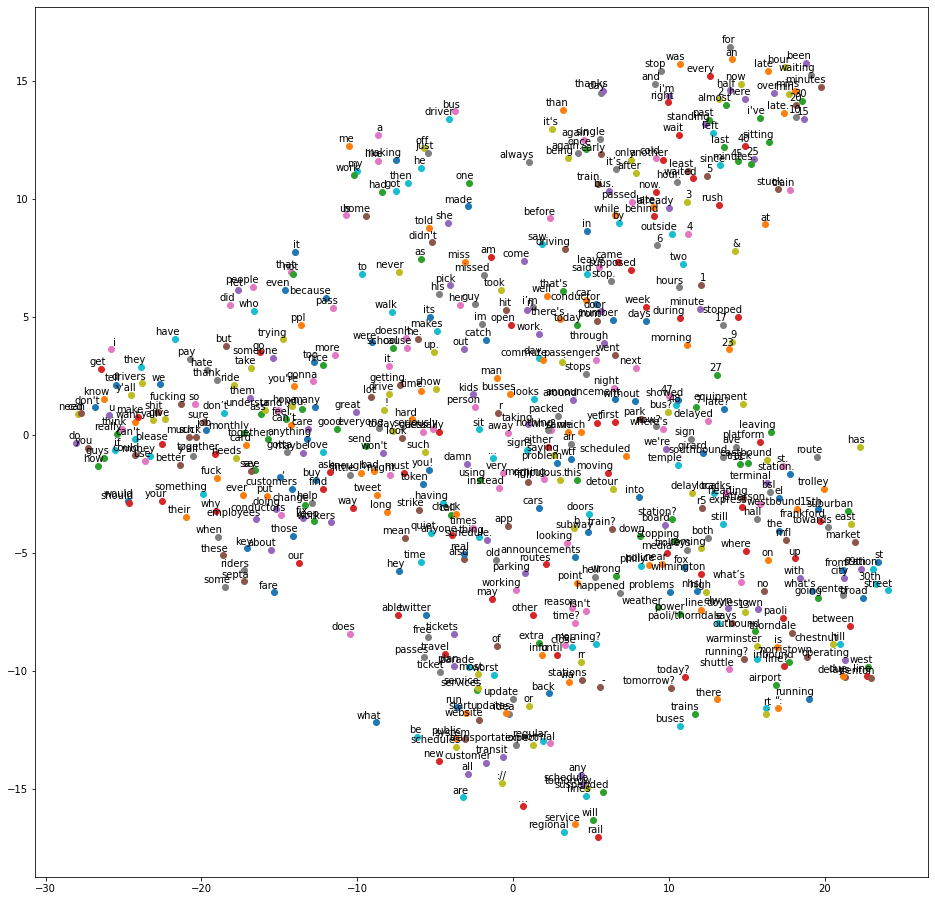

In [81]:
tsne_plot(w2v_model)

For the attentive eye, we can see a couple cool relationships emerge out of this visualization! 

1.) Note that "fuck", "thank", "ass", and "needs" are all super close to "customers" and "employees"!

2.) All of the numbers (which likely refer to stations) are grouped together on the middle-right!

3.) and more! (check out how things like regional, rail, transit are grouped, etc)

## Part 4: Challenges, Obstacles, and Future Discussion

**Challenges/Obstacles:** Albeit this is touched on in the individual sections, as a summary: most of the challenges faced in this project had to do with parts 2.4 and 3.3. 

*Part 2.4:* Since the number of features in train_df was so large (one-hot encoding all of the origins/destinations lead to 340+ columns) -- training a sufficiently large random forest took upwards of 3+ hours and exhausted the Collab RAM. Thus, a tradeoff had to be made between accuracy, training time/speed, and the size of the model; I ended up settling for 25 estimators and no-limits on the depth of the model.

Its also worth noting that, prior to settling on the Random Forest, I also trained a logistic regression model; this, however, performed quite poorly on the dataset ( < 0.5 accuracy). 

*Part 3.3:* It was quite difficult to train a sentiment classifier without having labeled SEPTA tweets. My first attempt was to use a CNN. However, this didn't work well -- as CNNs requrie a fixed-input size (which doesn't work with variable-length sentences) and don't effectively capture context.

My next approach was to train an LSTM (which was better suited for sentiment classifcation) on an IMDB movie review set. However, when the model was run on the SEPTA tweets, the results were super poor. I realized this was mainly because IMBD reviews were grammatical, didn't have slang, and had (at least some) sentence structure. Tweets were an entirely different story.

To compensate for this, I opted to train the LSTM on the Twitter140 sentiment dataset -- which gave much better results. 

*Other:* Other challenges included random issues with seaborn, effectively cleaning data, and generating plots that weren't subject to error (for example, in part 1.4, I didn't realize that one of the stations only had 8 records, so although it had the highest average delay, that was simply the result of one unfortunate day).

**Future Improvements:** If I had more time, I imagine I could've iterated on the Random Forest Regressor (made it more robust, possibly parallelized it) to improve delay predictions. There's also possibly room here for 
experimentation with RNNs. It would've also been interesting to do more EDA in part 1 on the correlation between being late to one station -> effect on other stations. 

There is also room for improvement with the sentiment classifier. A more ideal approach (time permitting) would've entailed labeling the SEPTA tweets and training on *that*, rather than a generalized Twitter dataset. It would've also been interesting to figure out how to detect sarcasm in text -- as some of the positively-classified tweets, were, in reality, pretty negative (i.e. "Yo! Huge, huge thanks to SEPTA for absolutely nothing!") 